In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import arviz as az
import pymc3 as pm
%matplotlib inline
palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Overfitting vs underfitting

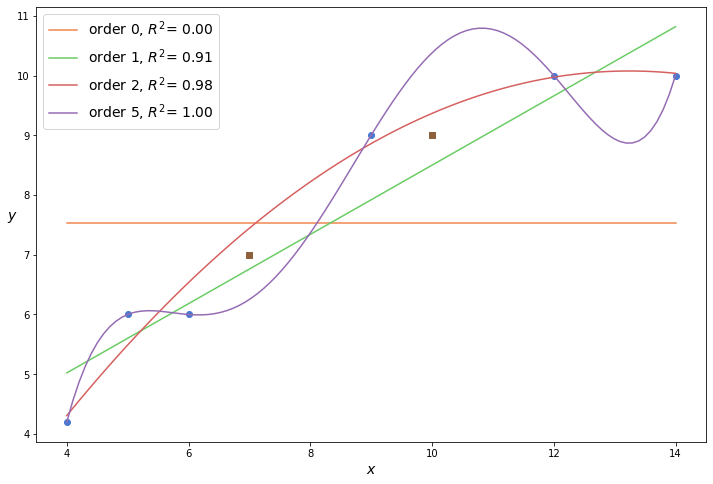

In [31]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
# order = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 8))
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)     # thay x vao
    ybar = np.mean(y)

    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2, fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)

# collect more data points to test the best line
plt.plot([10, 7], [9, 7], 's')

(-7.0, 7.0)

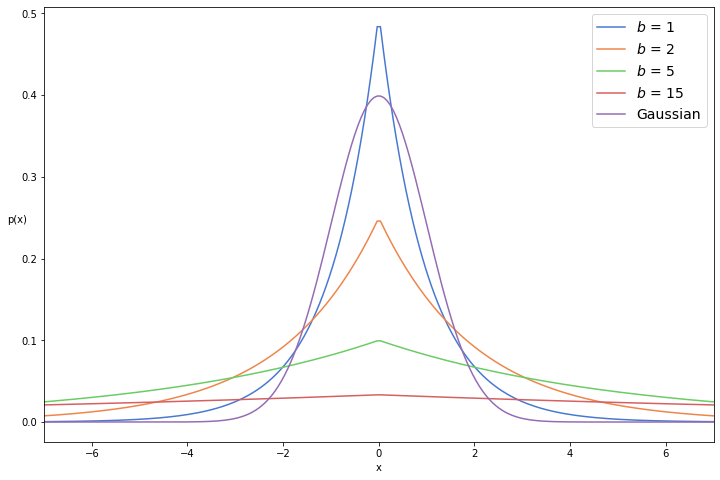

In [34]:
plt.figure(figsize=(12, 8))

x_values = np.linspace(-10, 10, 300)

# laplace dis part
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f'$b$ = {df}')

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')

plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)

plt.xlim(-7, 7)

In [36]:
x_1 = np.array([10.,   8.,  13.,   9.,  11.,
               14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
                10.84,   4.82,   5.68])

# Computing information criteria

In [37]:
np.random.seed(1)
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20

noise = np.random.normal(0, 2, size=data_size)

x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

Text(0, 0.5, '$y$')

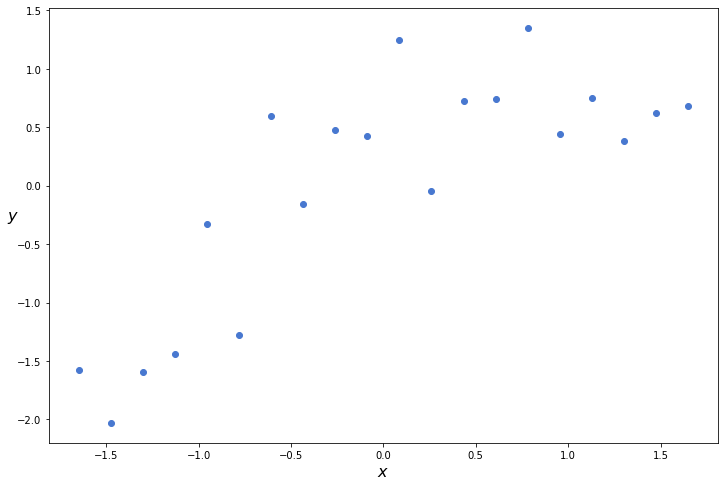

In [38]:
order = 2  # 5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
    x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()

plt.figure(figsize=(12, 8))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

In [39]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta * x_1s[0]

    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)

    trace_l = pm.sampling.sample(2100, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_100 draw iterations (2_000 + 4_200 draws total) took 31 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>]], dtype=object)

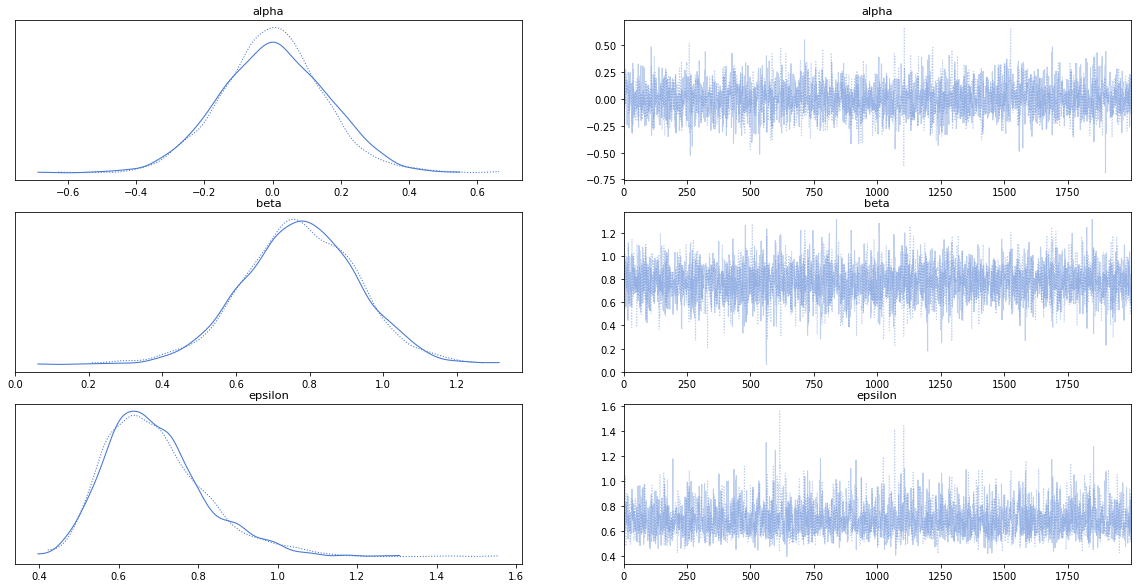

In [40]:
chain_l = trace_l[100:]
pm.plot_trace(chain_l, figsize=(20, 10))

In [41]:
pm.summary(chain_l)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.153,-0.295,0.281,0.003,0.003,3350.0,2551.0,1.0
beta,0.774,0.157,0.473,1.061,0.002,0.002,4424.0,2808.0,1.0
epsilon,0.693,0.127,0.464,0.922,0.002,0.002,3189.0,2556.0,1.0


In [42]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, x_1s)

    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)

    trace_p = pm.sampling.sample(2100, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_100 draw iterations (2_000 + 4_200 draws total) took 29 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>]], dtype=object)

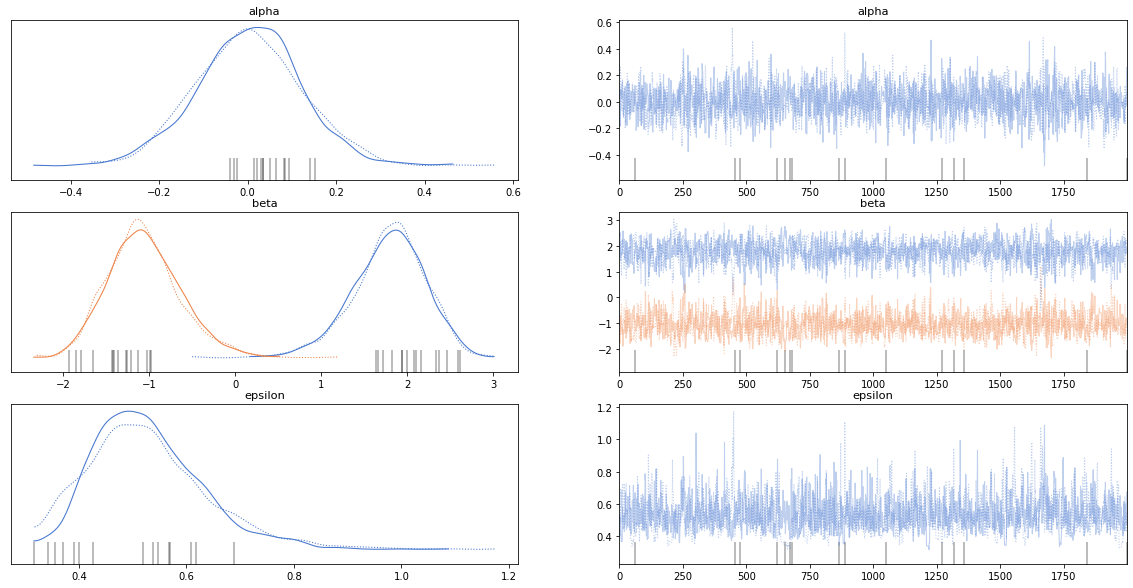

In [43]:
chain_p = trace_p[100:]
pm.plot_trace(chain_p, figsize=(20, 10))

In [44]:
pm.summary(chain_p)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.003,0.120,-0.219,0.231,0.003,0.002,1883.0,1601.0,1.0
beta[0],1.788,0.423,1.005,2.574,0.013,0.009,1140.0,1090.0,1.0
beta[1],-1.055,0.422,-1.794,-0.238,0.013,0.009,1107.0,1023.0,1.0
epsilon,0.529,0.109,0.337,0.722,0.004,0.003,625.0,283.0,1.0


plot the results as the best-fitted lines

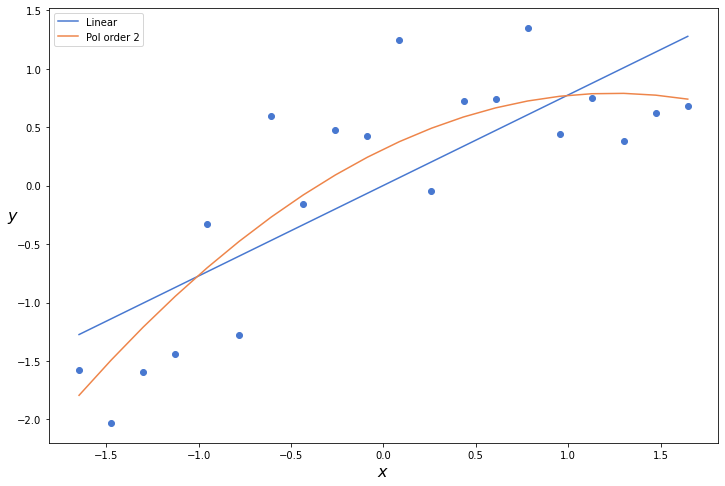

In [47]:
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)

plt.figure(figsize=(12, 8))

idx = np.argsort(x_1s[0])

y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')


alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label=f'Pol order {order}')

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend()


# Information criteria

In [ ]:
# dic_l = pm.dic(trace=trace_l, model=model_l)
# dic_l

In [ ]:
# dic_p = pm.dic(trace=trace_p, model=model_p)
# dic_p

In [49]:
waic_l = pm.waic(trace_l, model_l)
waic_l

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 4200 by 20 log-likelihood matrix

          Estimate       SE
elpd_waic   -21.31     2.02
p_waic        2.12        -

In [50]:
waic_p = pm.waic(trace_p, model_p)
waic_p

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 4200 by 20 log-likelihood matrix

          Estimate       SE
elpd_waic   -16.45     2.32
p_waic        2.76        -

In [51]:
loo_l = az.loo(trace_l, model_l)
loo_l

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 4200 by 20 log-likelihood matrix

         Estimate       SE
elpd_loo   -21.36     2.04
p_loo        2.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [52]:
loo_p = az.loo(trace_p, model_p)
loo_p

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 4200 by 20 log-likelihood matrix

         Estimate       SE
elpd_loo   -16.54     2.34
p_loo        2.85        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       19   95.0%
 (0.5, 0.7]   (ok)          1    5.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

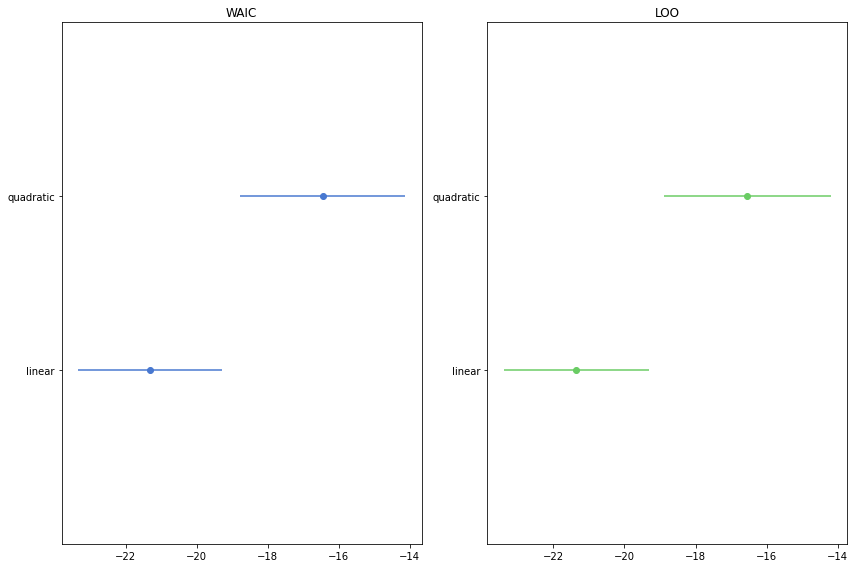

In [54]:
plt.figure(figsize=(12, 8))

plt.subplot(121)

for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
    
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)

for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='go')
    
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.tight_layout()

## Posterior predictive checks

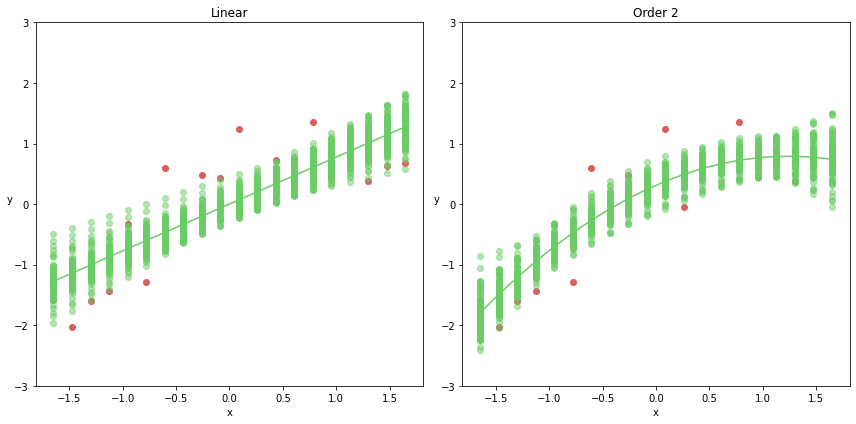

In [59]:
plt.figure(figsize=(12, 6))

# linear part
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='r')

plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')

for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='g',
                edgecolors='g', alpha=0.5)
plt.plot(x_1s[0], chain_l['alpha'].mean() +
         chain_l['beta'].mean()*x_1s[0], c='g', alpha=1)

# order 2 part
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='r')

plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title(f'Order {order}')

for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='g',
                edgecolors='g', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post +
         np.dot(betas_p_post, x_1s)[idx], c='g', alpha=1)

plt.tight_layout()


# Bayes factors

In [63]:
coins, heads = 30, 9
y = np.repeat([0, 1], [coins-heads, heads])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [74]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    
    m_0, m_1 = (4, 8), (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    
    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    print(theta)

    # likelihood
    y = pm.Bernoulli('y', theta, observed=y)
     
    trace_BF = pm.sampling.sample(5000, return_inferencedata=False)

Subtensor{int64}.0 Subtensor{int64}.0


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


0.9161111111111111 0.08388888888888889 10.920529801324504


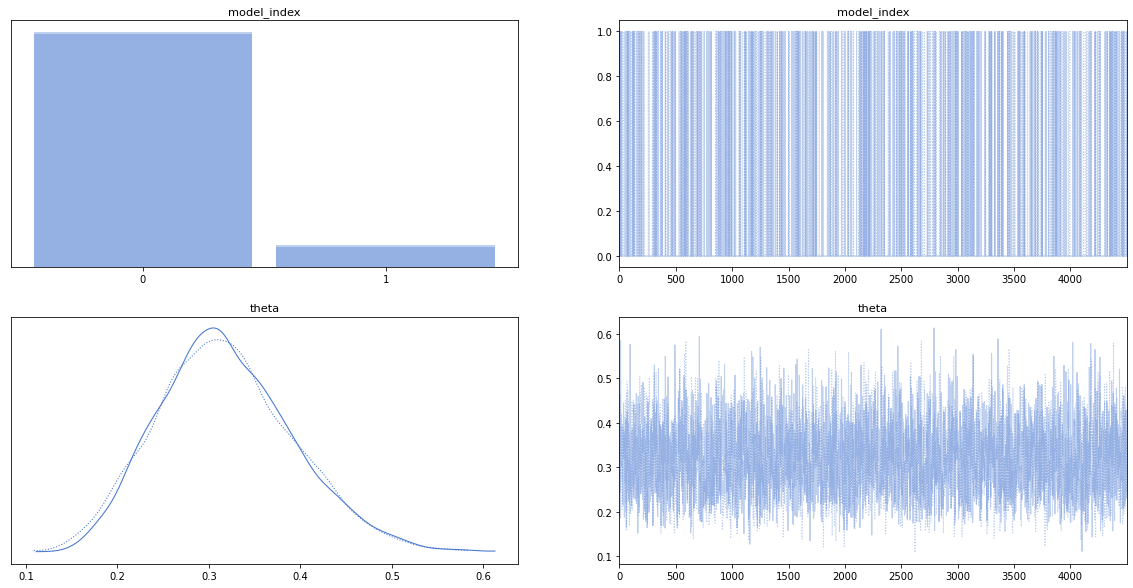

In [65]:
chain_BF = trace_BF[500:]
pm.plot_trace(chain_BF, figsize=(20, 10))

pM1 = chain_BF['model_index'].mean()
pM0 = 1 - pM1

print(pM0, pM1, (pM0/pM1)*(p[1]/p[0]))

In [76]:
coins, heads = 300, 90
y = np.repeat([0, 1], [coins-heads, heads])

In [77]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y)
    
    trace_BF_0 = pm.sampling.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  This is separate from the ipykernel package so we can avoid doing imports until


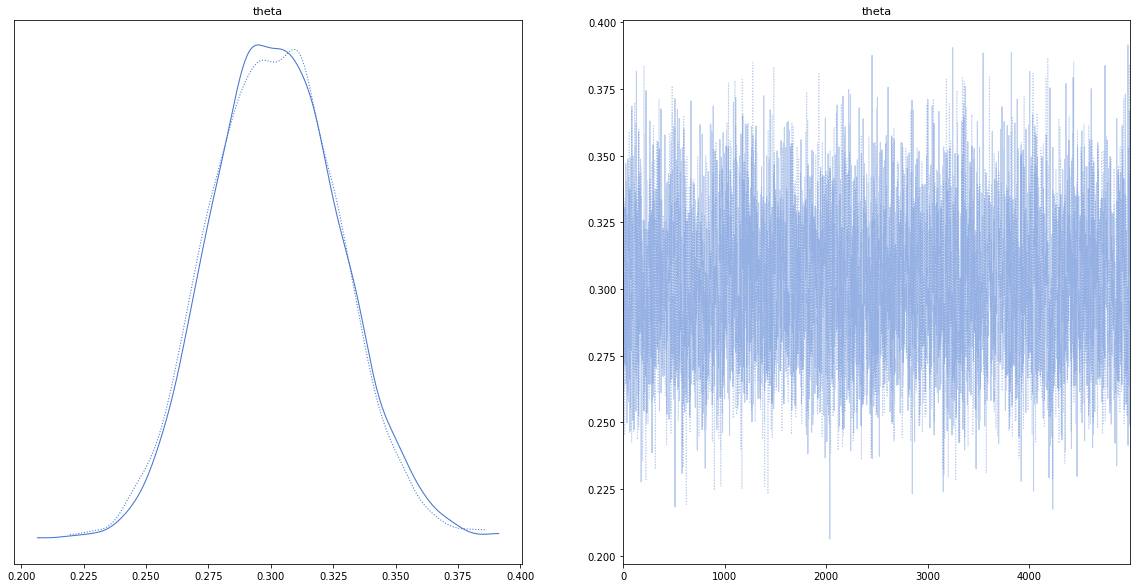

In [78]:
chain_BF_0 = trace_BF_0[500:]
pm.plot_trace(trace_BF_0, figsize=(20, 10))

In [80]:
coins, heads = 300, 90
y = np.repeat([0, 1], [coins-heads, heads])

In [81]:
with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y)
    
    trace_BF_1 = pm.sample(5000)

e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 28 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

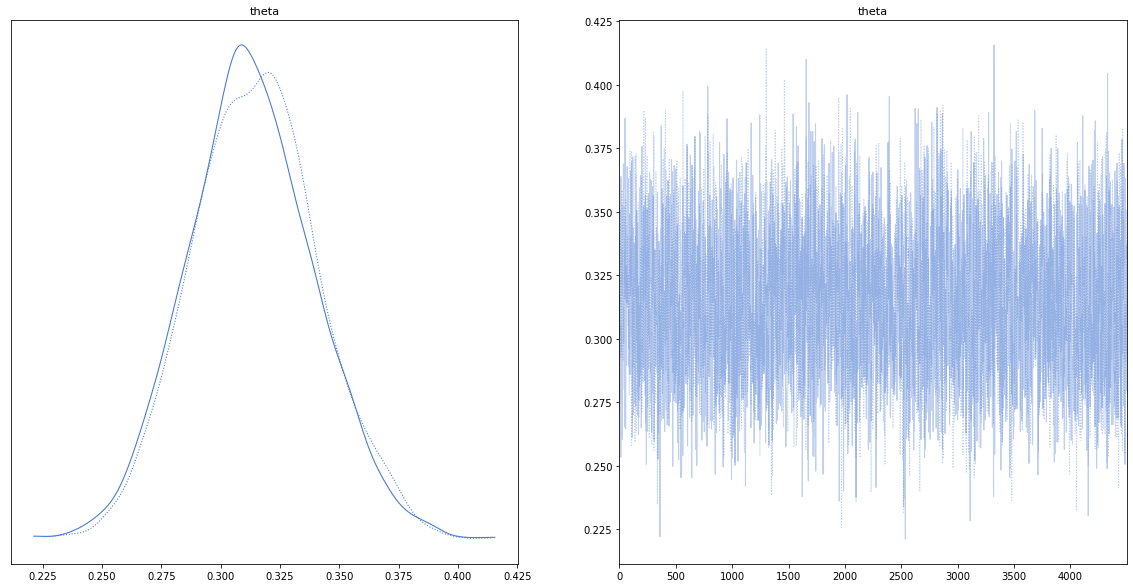

In [82]:
chain_BF_1 = trace_BF_1[500:]
pm.plot_trace(chain_BF_1, figsize=(20, 10))

In [83]:
waic_0 = pm.waic(chain_BF_0, model_BF_0)
waic_0

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 9000 by 300 log-likelihood matrix

          Estimate       SE
elpd_waic  -184.20     6.70
p_waic        0.94        -

In [84]:
waic_1 = pm.waic(chain_BF_1, model_BF_1)
waic_1

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 9000 by 300 log-likelihood matrix

          Estimate       SE
elpd_waic  -184.36     6.25
p_waic        0.97        -

In [85]:
loo_0 = pm.loo(chain_BF_0, model_BF_0)
loo_0

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 9000 by 300 log-likelihood matrix

         Estimate       SE
elpd_loo  -184.20     6.70
p_loo        0.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      300  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [86]:
loo_1 = pm.loo(chain_BF_1, model_BF_1)
loo_1

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 9000 by 300 log-likelihood matrix

         Estimate       SE
elpd_loo  -184.36     6.25
p_loo        0.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      300  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

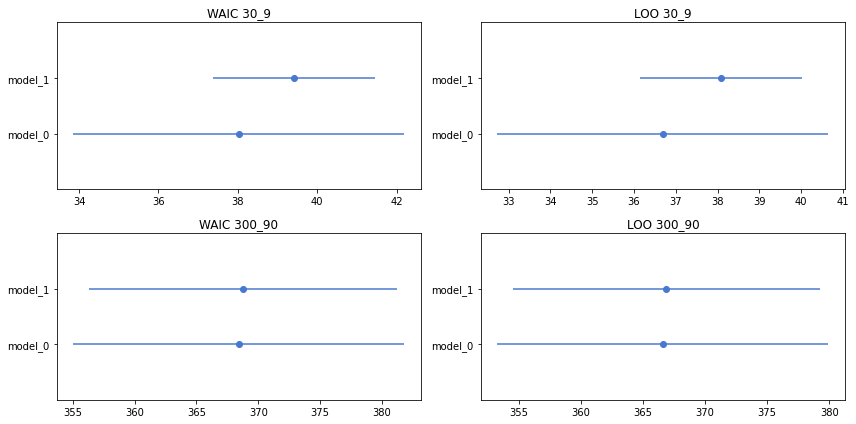

In [88]:
est = [((38.02, 4.17), (39.41, 2.04)), ((36.69, 3.96), (38.09, 1.94)),
       ((368.41, 13.40), (368.76, 12.48)), ((366.61, 13.31), (366.87, 12.34))]

title = ['WAIC 30_9', 'LOO 30_9', 'WAIC 300_90', 'LOO 300_90']

plt.figure(figsize=(12, 6))

for i in range(4):
    plt.subplot(2, 2, i+1)
    for idx, ic in enumerate(est[i]):
        plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
    plt.title(title[i])
    plt.yticks([0, 1], ['model_0', 'model_1'])
    plt.ylim(-1, 2)

plt.tight_layout()